In [1]:
from dotenv import load_dotenv
import os
from src.plot import get_pred_and_true_workloads
import matplotlib.pyplot as plt
import numpy as np

load_dotenv()

True

In [2]:
BASE_PATH = '/Users/ashfaq/Documents/noisy_data_preds'
TRAINING_NODE=25
TESTING_NODE=25

In [3]:
output_dir = f'../plots/noisy_tests/microservice_train_{TRAINING_NODE}_test_{TESTING_NODE}'

In [4]:
RESULTS_BASE_PATH = os.path.join(BASE_PATH, f'microservice_train_{TRAINING_NODE}_test_{TESTING_NODE}')

In [5]:
variants = [
    'univariate_3_without_embedding',
    'univariate_3_with_embedding',
    'univariate_12_without_embedding',
    'univariate_12_with_embedding',
    'univariate_24_without_embedding',
    'univariate_24_with_embedding',
    'univariate_60_without_embedding',
    'univariate_60_with_embedding',
    'multivariate_3_without_embedding',
    'multivariate_3_with_embedding'
]

In [6]:
seeds = list(range(40, 50))

In [7]:
from collections import OrderedDict
from src.utils import list_folders_in_directory


def get_data(variant, seed):
    data_path = os.path.join(RESULTS_BASE_PATH, variant, f'seed_{seed}')
    directories = list_folders_in_directory(data_path)
    
    data_dict = {}
    
    for dir_name in directories:
        mod_factor = float(dir_name.split('_')[-1])
        metrics = np.load(os.path.join(data_path, dir_name, 'metrics.npy'))
        preds = np.load(os.path.join(data_path, dir_name, 'preds.npy'))
        trues = np.load(os.path.join(data_path, dir_name, 'trues.npy'))
        data_dict[mod_factor] = {
            'metrics': metrics,
            'preds': preds,
            'trues': trues
        }
    
    sorted_dict = OrderedDict(sorted(data_dict.items()))
    return sorted_dict

In [8]:
def plot_metrics(seed):
    all_maes = []
    all_mses = []
    all_mapes = []
    
    selected_variants = variants[:8]
    
    for variant in selected_variants:
        all_data = get_data(variant, seed)
    
        maes = []
        mses = []
        mapes = []
    
        for mod_factor, data in all_data.items():
            metrics = data['metrics']
            maes.append(metrics[0])
            mses.append(metrics[1])
            mapes.append(metrics[3])
            
        all_maes.append(maes)
        all_mses.append(mses)
        all_mapes.append(mapes)
        
    mod_factors = np.arange(0.0, 1.01, 0.01)

    # Create a figure with 3 rows and 1 column
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Plot MAEs for all variants
    for i, variant in enumerate(selected_variants):
        axes[0].plot(mod_factors, all_maes[i], label=variant)
    axes[0].set_title('Mean Absolute Error (MAE)')
    axes[0].set_xlabel('Modulation Factor')
    axes[0].set_ylabel('MAE')
    axes[0].grid(True)
    axes[0].legend(loc='best')

    # Plot MSEs for all variants
    for i, variant in enumerate(selected_variants):
        axes[1].plot(mod_factors, all_mses[i], label=variant)
    axes[1].set_title('Mean Squared Error (MSE)')
    axes[1].set_xlabel('Modulation Factor')
    axes[1].set_ylabel('MSE')
    axes[1].grid(True)
    axes[1].legend(loc='best')
    
    # Plot MAPEs for all variants
    for i, variant in enumerate(selected_variants):
        axes[2].plot(mod_factors, all_mapes[i], label=variant)
    axes[2].set_title('Mean Absolute Percentage Error (MAPE)')
    axes[2].set_xlabel('Modulation Factor')
    axes[2].set_ylabel('MAPE')
    axes[2].grid(True)
    axes[2].legend(loc='best')

    plt.tight_layout()
    
    output_path = os.path.join(output_dir, f'seed_{seed}')
    os.makedirs(output_path, exist_ok=True)
    
    plt.savefig(os.path.join(output_path, 'metrics.png'))
    plt.show()

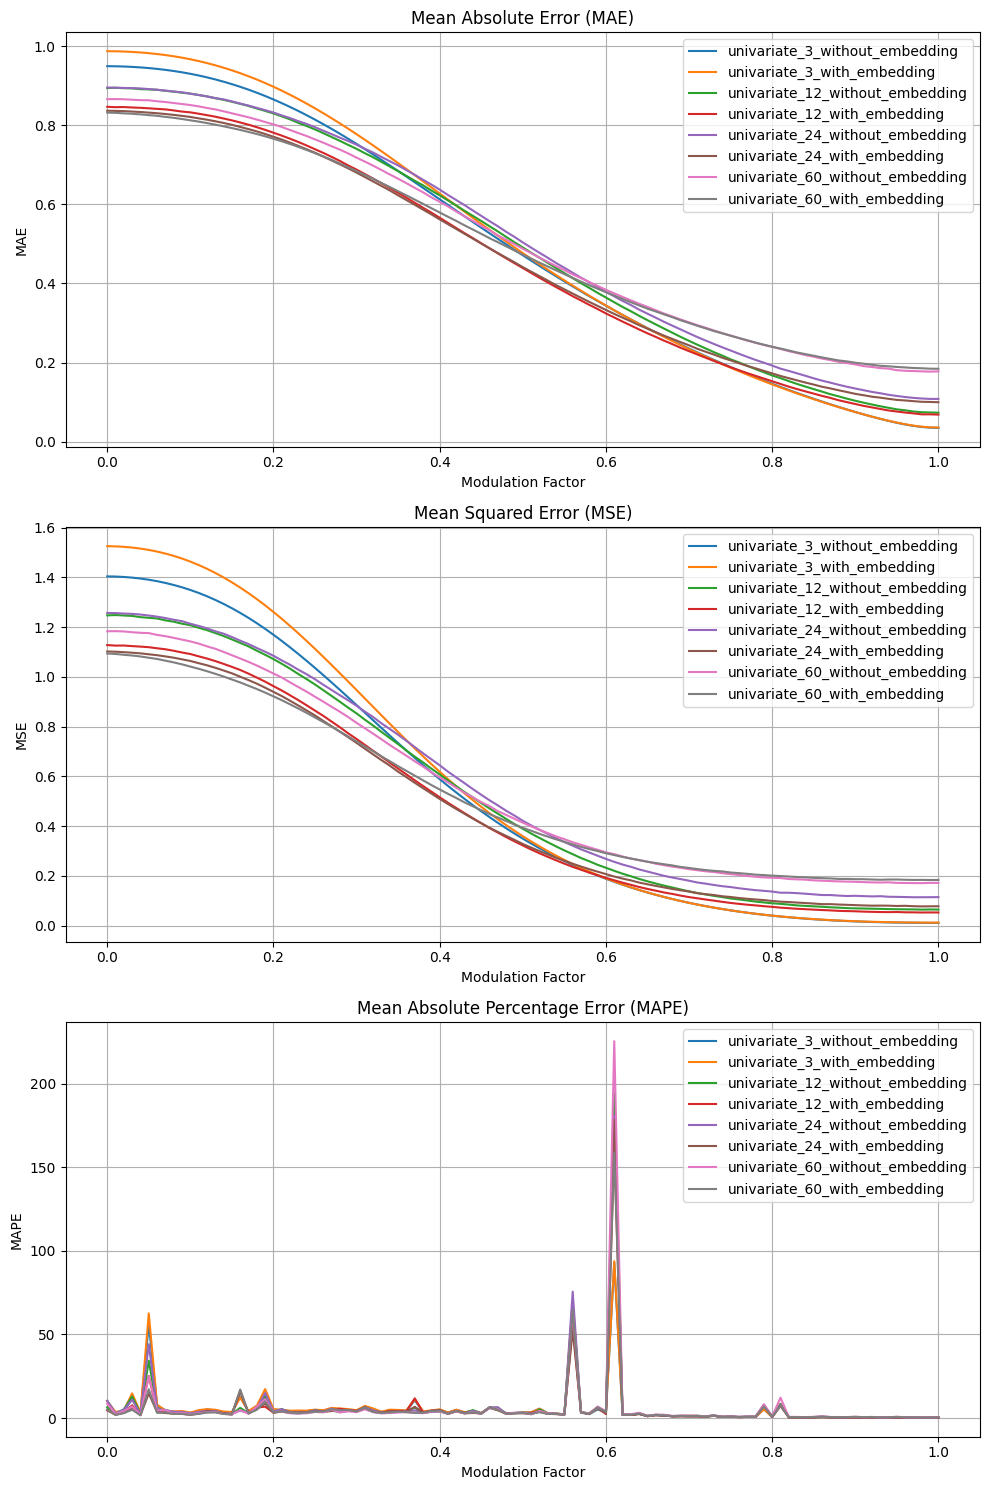

In [9]:
plot_metrics(seeds[0])

In [10]:
def plot_preds(variant, seed, n_graphs=8):
    is_multivariate = variant.startswith('multivariate')
    microservice_id = TESTING_NODE if is_multivariate else None
    all_data = get_data(variant, seed)
    
    train_days = int(os.getenv('WORKLOAD_PREDICTION_TRAINING_DAYS'))
    valid_days = int(os.getenv('WORKLOAD_PREDICTION_VALIDATION_DAYS'))
    test_days = int(os.getenv('WORKLOAD_PREDICTION_TEST_DAYS'))
    
    start_day = train_days + valid_days
    end_day = start_day + test_days
    
    mod_factors = list(all_data.keys())
    step = len(mod_factors) // (n_graphs - 1)

    selected_mod_factors = [mod_factors[i] for i in range(0, len(mod_factors), step)][:n_graphs]
    
    selected_preds = []
    maes = []
    
    for mod_factor in selected_mod_factors:
        preds = all_data[mod_factor]['preds']
        trues = all_data[mod_factor]['trues']
        
        mae = all_data[mod_factor]['metrics'][0]
        maes.append(mae)
        
        flattened_preds, flattened_trues = get_pred_and_true_workloads(preds, trues, microservice_id)
        selected_preds.append((flattened_preds, flattened_trues))
        
    fig, axes = plt.subplots(n_graphs, 2, figsize=(12, 4 * n_graphs))
    
    minutes_per_day = 1440
    x_values = np.arange(0, test_days * minutes_per_day)
    days = np.arange(0, test_days + 1)
    day_labels = [str(day + start_day) for day in days]

    for i, (preds, trues) in enumerate(selected_preds):
        axes[i, 0].plot(trues, label='True Values', color='lightgreen', linestyle=':', linewidth=1)
        axes[i, 0].set_title(f'Modulation Factor {selected_mod_factors[i]} - True Values')
        axes[i, 0].legend()
        axes[i, 0].grid(True)
        axes[i, 0].set_xlabel('Day')
        axes[i, 0].set_ylabel('CPM')
        axes[i, 0].set_xticks(days * minutes_per_day)
        axes[i, 0].set_xticklabels(day_labels)

        axes[i, 1].plot(preds, label='Predictions', color='b', linewidth=2)
        axes[i, 1].set_title(f'Modulation Factor {selected_mod_factors[i]} - Predictions (MAE: {maes[i]:.4f})')
        axes[i, 1].legend()
        axes[i, 1].grid(True)
        axes[i, 1].set_xlabel('Day')
        axes[i, 1].set_ylabel('CPM')
        axes[i, 1].set_xticks(days * minutes_per_day)
        axes[i, 1].set_xticklabels(day_labels)

        y_min = min(min(trues), min(preds))
        y_max = max(max(trues), max(preds))
        axes[i, 0].set_ylim([y_min, y_max])
        axes[i, 1].set_ylim([y_min, y_max])
    
    output_path = os.path.join(output_dir, f'seed_{seed}')
    os.makedirs(output_path, exist_ok=True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f'plots_{variant}.png'))
    plt.show()

In [11]:
float_values = np.arange(0.0, 1.01, 0.01)

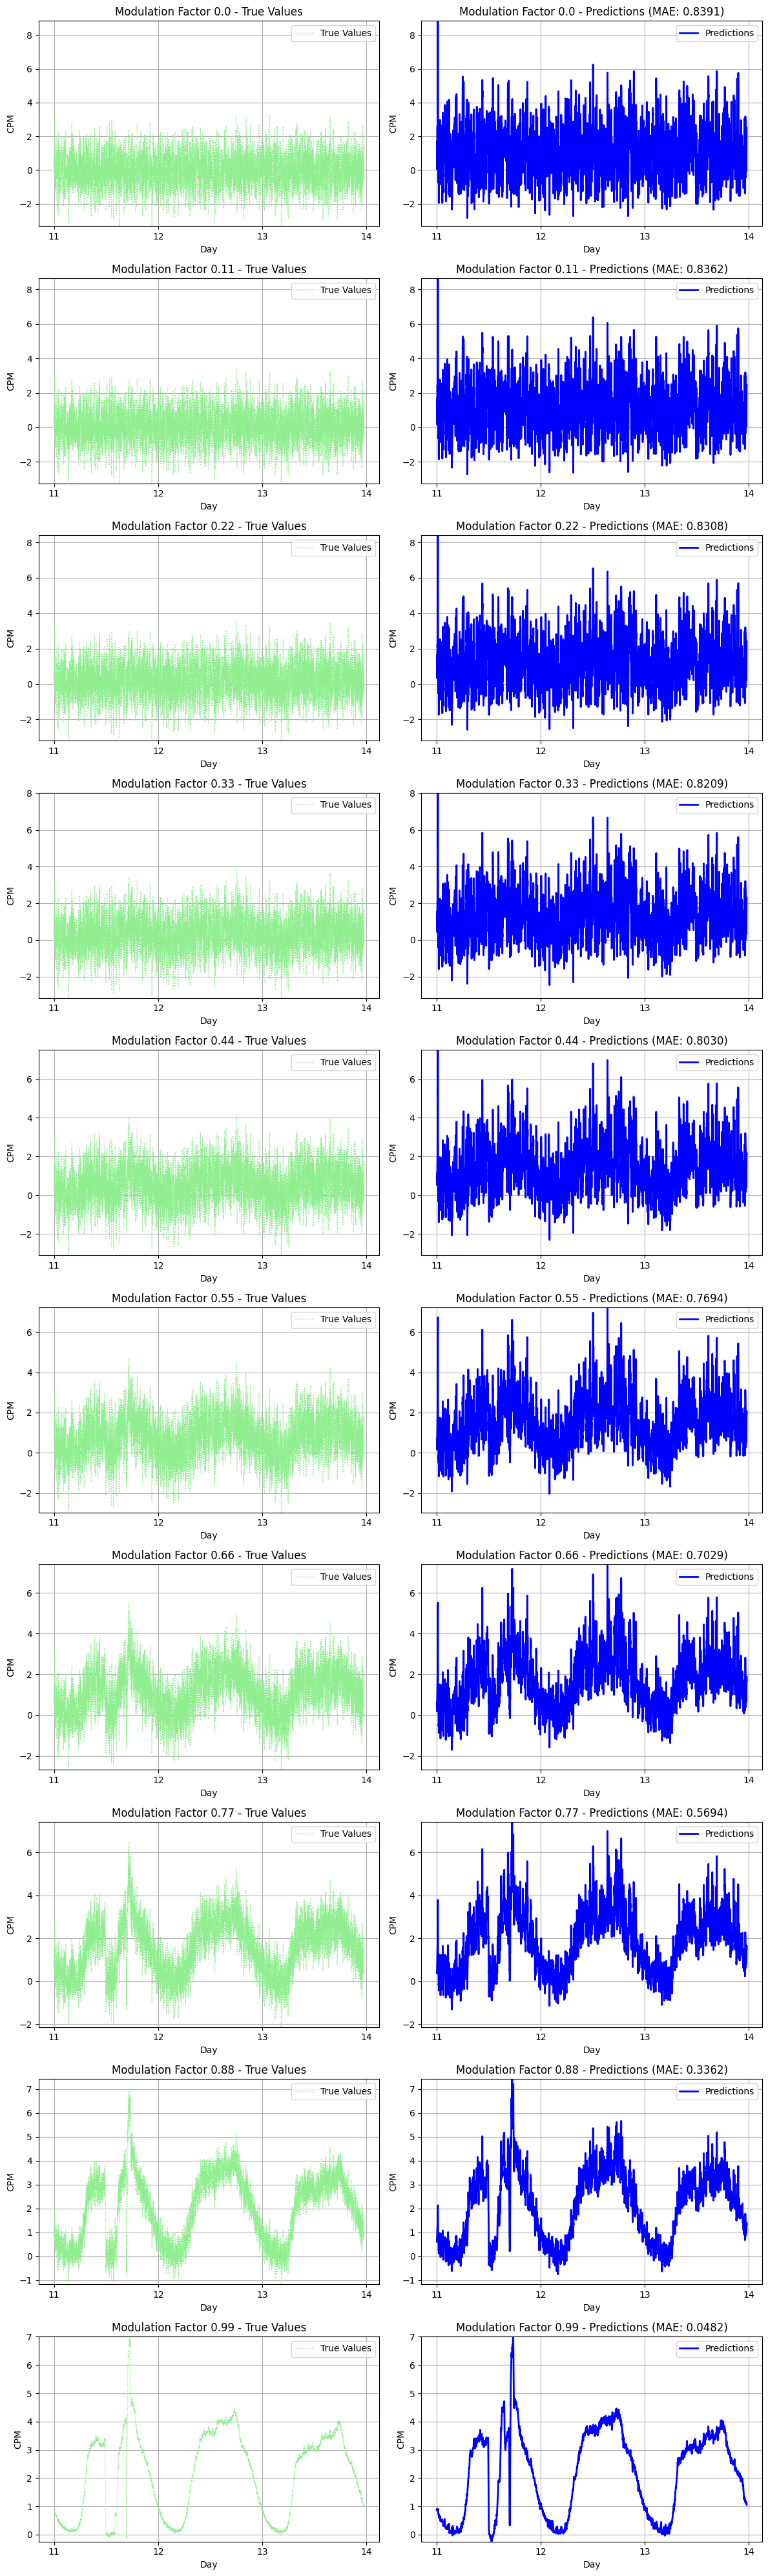

In [14]:
plot_preds(variants[8], seeds[0], n_graphs=10)